In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string as str
import glob
import os

# Load and preview the files

### Engagement data
The engagement data are aggregated at school district level, and each file in the folder `engagement_data` represents data from one school district. The 4-digit file name represents `district_id` which can be used to link to district information in `district_info.csv`. The `lp_id` can be used to link to product information in `product_info.csv`.

| Name | Description |
| :--- | :----------- |
| time | date in "YYYY-MM-DD" |
| lp_id | The unique identifier of the product |
| pct_access | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day |

In [2]:
#Load and combine files in engagement folder
path="engagement_data"
list_engagement=[]

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        df=pd.read_csv(os.path.join(dirname, filename))
        df['district_id']=filename.split('.')[0]
        list_engagement.append(df)
        
engagement_df=pd.concat(list_engagement)
engagement_df.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,93690.0,0.00,NaN,1000
1,2020-01-01,17941.0,0.03,0.90,1000
2,2020-01-01,65358.0,0.03,1.20,1000
3,2020-01-01,98265.0,0.57,37.79,1000
4,2020-01-01,59257.0,0.00,NaN,1000


### District information data

The district file `districts_info.csv` includes information about the characteristics of school districts, including data from [NCES](https://nces.ed.gov/) (2018-19), [FCC](https://www.fcc.gov/) (Dec 2018), and [Edunomics Lab](https://edunomicslab.org/). In this data set, we removed the identifiable information about the school districts. We also used an open source tool [ARX](https://arx.deidentifier.org/) [(Prasser et al. 2020)](https://onlinelibrary.wiley.com/doi/full/10.1002/spe.2812) to transform several data fields and reduce the risks of re-identification. For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset. 

| Name | Description |
| :--- | :----------- |
| district_id | The unique identifier of the school district |
| state | The state where the district resides in |
| locale | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See [Locale Boundaries User's Manual](https://eric.ed.gov/?id=ED577162) for more information. |
| pct_black/hispanic | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data |
| pct_free/reduced | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data |
| county_connections_ratio | `ratio` (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See [FCC data](https://www.fcc.gov/form-477-county-data-internet-access-services) for more information. |
| pp_total_raw | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |

In [4]:
#Load the districts_info file
district_df=pd.read_csv('districts_info.csv')
district_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


### Product information data
The product file `products_info.csv` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. Data were labeled by our team. Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

| Name | Description |
| :--- | :----------- |
| LP ID| The unique identifier of the product |
| URL | Web Link to the specific product |
| Product Name | Name of the specific product |
| Provider/Company Name | Name of the product provider |
| Sector(s) | Sector of education where the product is used |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |

In [5]:
#Load the products_info file
product_df=pd.read_csv('products_info.csv')
product_df.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


# Preprocessing

In this step, I will handle:
- The missing value in engagement_df, district_df, product_df
- Formating the [float] type to float type
- Split main categories and sub categories from 'Primary Essential Function' column in product_df

## Missing value

In [6]:
#Check number of missing values in engagement_df
print(engagement_df.isnull().sum())

print('\nPreview the data where engagement_index is recorded but pct_access is not recorded:')
print(engagement_df[engagement_df.pct_access.isnull() & engagement_df.engagement_index.notnull()].head())

time                      0
lp_id                   541
pct_access            13447
engagement_index    5378409
district_id               0
dtype: int64

Preview the data where engagement_index is recorded but pct_access is not recorded:
Empty DataFrame
Columns: [time, lp_id, pct_access, engagement_index, district_id]
Index: []


In [3]:
engagement_df[engagement_df.engagement_index==0].head()

,time,lp_id,pct_access,engagement_index,district_id


Recall that:
- **pct_access** is "Percentage of students in the district have at least one page-load event of a given product and on a given day"
- **engagement_index** is "Total page-load events per one thousand students of a given product and on a given day"

I suppose that engagement_index is NaN on the day when there is no page_load of a specific product.
And if lp_id is NaN, we cannot connect it with the product_df, therefore we do not know the information about the product.
So I will remove the rows contains the null value at these 2 columns.

In [7]:
#Drop rows with null values in the engagement_index and lp_id column
engagement_df.dropna(subset=['engagement_index','lp_id'], inplace=True)

In [8]:
#Check the number of missing values in the district_df
print(district_df.shape)
district_df.isnull().sum()

(233, 7)


district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64

Recall, '...there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset'. I will remove all rows that do not have information.

In [9]:
district_df.dropna(inplace=True)

In [10]:
print(product_df.shape)
print(product_df.isnull().sum())

(372, 6)
LP ID                          0
URL                            0
Product Name                   0
Provider/Company Name          1
Sector(s)                     20
Primary Essential Function    20
dtype: int64


In [11]:
product_df.dropna(inplace=True)

## Formating the data

In [18]:
#Change the data type of product id and district id in engagement_df column
engagement_df.lp_id=engagement_df.lp_id.astype('int64')
engagement_df.district_id=engagement_df.district_id.astype('int64')
engagement_df.dtypes

time                 object
lp_id                 int64
pct_access          float64
engagement_index    float64
district_id           int64
dtype: object

In [13]:
district_df.dtypes

district_id                  int64
state                       object
locale                      object
pct_black/hispanic          object
pct_free/reduced            object
county_connections_ratio    object
pp_total_raw                object
dtype: object

In [14]:
district_df['pp_total_raw'].unique()

array(['[14000, 16000[', '[6000, 8000[', '[10000, 12000[',
       '[8000, 10000[', '[12000, 14000[', '[18000, 20000[',
       '[22000, 24000[', '[16000, 18000[', '[4000, 6000[',
       '[32000, 34000['], dtype=object)

In [15]:
# Change the interval in the district_df to single float number
columns=['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']
for column in columns:
    district_df[column]=district_df[column].apply(lambda x: (float(x.split(',')[0][1:]) + float(x.split(',')[1][:-1]))/2)
district_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,0.1,0.1,0.59,15000.0
2,4921,Utah,Suburb,0.1,0.3,0.59,7000.0
5,5987,Wisconsin,Suburb,0.1,0.1,0.59,11000.0
6,3710,Utah,Suburb,0.1,0.5,0.59,7000.0
7,7177,North Carolina,Suburb,0.3,0.3,0.59,9000.0


In [16]:
#Split main categories and sub categories from 'Primary Essential Function' column in product_df
product_df['sub_function']=product_df['Primary Essential Function'].apply(lambda x: x.split(' - ')[1])
product_df['main_function']=product_df['Primary Essential Function'].apply(lambda x: x.split(' - ')[0])
product_df.drop('Primary Essential Function', axis=1, inplace=True)
product_df.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),sub_function,main_function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,Digital Learning Platforms,LC
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,Digital Learning Platforms,LC
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"Sites, Resources & Reference",LC
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,Digital Learning Platforms,LC
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,Digital Learning Platforms,LC


In [19]:
#Combine the 3 dataframes to one:
temp=engagement_df.merge(district_df, on='district_id')
df=temp.merge(product_df,left_on='lp_id', right_on='LP ID')
df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,LP ID,URL,Product Name,Provider/Company Name,Sector(s),sub_function,main_function
0,2020-01-01,32213,0.90,44.23,1052,Illinois,Suburb,0.3,0.3,0.59,17000.0,32213,https://classroom.google.com,Google Classroom,Google LLC,PreK-12; Higher Ed; Corporate,Learning Management Systems (LMS),SDO
1,2020-01-02,32213,1.60,122.85,1052,Illinois,Suburb,0.3,0.3,0.59,17000.0,32213,https://classroom.google.com,Google Classroom,Google LLC,PreK-12; Higher Ed; Corporate,Learning Management Systems (LMS),SDO
2,2020-01-03,32213,1.39,108.93,1052,Illinois,Suburb,0.3,0.3,0.59,17000.0,32213,https://classroom.google.com,Google Classroom,Google LLC,PreK-12; Higher Ed; Corporate,Learning Management Systems (LMS),SDO
3,2020-01-04,32213,1.76,112.61,1052,Illinois,Suburb,0.3,0.3,0.59,17000.0,32213,https://classroom.google.com,Google Classroom,Google LLC,PreK-12; Higher Ed; Corporate,Learning Management Systems (LMS),SDO
4,2020-01-05,32213,2.70,198.20,1052,Illinois,Suburb,0.3,0.3,0.59,17000.0,32213,https://classroom.google.com,Google Classroom,Google LLC,PreK-12; Higher Ed; Corporate,Learning Management Systems (LMS),SDO


# Exploratory Data Analytics

### How many are school districts in each state, locale?

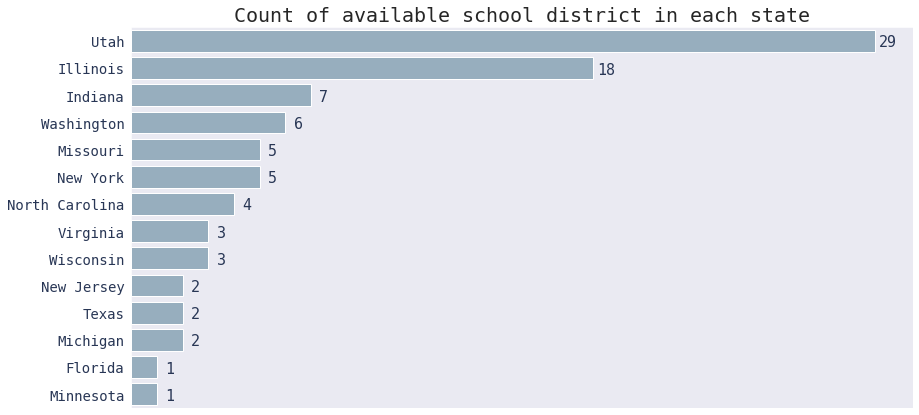

In [55]:
plt.figure(figsize=(14,7))
a=sns.barplot(y='index', x='state', data=district_df.state.value_counts().reset_index(drop=False), color='#90afc5')
plt.title('Count of available school district in each state',fontdict = {'fontsize':20, 'fontname':'monospace'})
plt.xticks([])
plt.yticks(fontname = 'monospace', fontsize = 14, color = '#283655')
plt.ylabel('')
plt.xlabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(0.5 + width, p.get_y() + 0.55 * p.get_height(), f'{int(width)}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 15, color = '#283655')

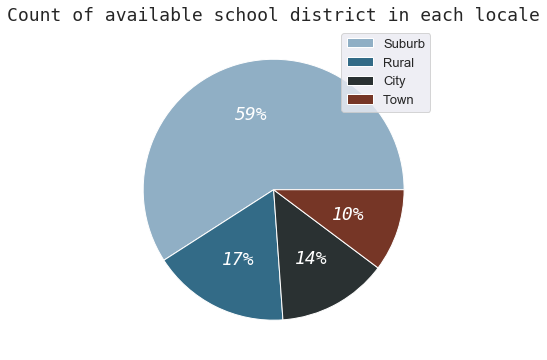

In [95]:
locale_district=district_df.locale.value_counts().reset_index().rename(columns={'locale':'count_district','index':'locale'})

colors = ['#90afc5','#336b87','#2a3132','#763626']
sns.set_style("dark")
ax=plt.figure(figsize=(10,6))
plt.pie(locale_district.count_district, labels=None, colors=colors, autopct='%.0f%%', textprops={'color':"w", 'fontsize':18,'fontname':'monospace','fontstyle':'italic'})
plt.title('Count of available school district in each locale',fontdict = {'fontsize':18, 'fontname':'monospace'})
plt.legend(locale_district.locale, loc='upper right', fontsize=13)

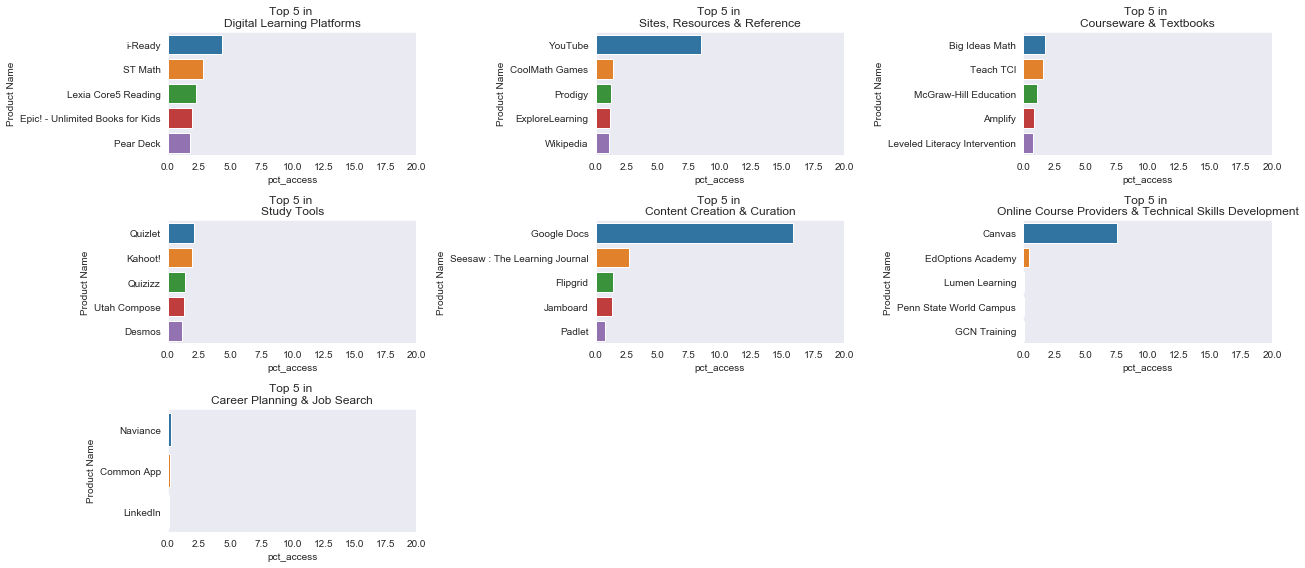

In [113]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))

i = 0
j = 0

for sub_function in product_df[product_df.main_function=='LC'].sub_function.unique():

    temp1=engagement_df.groupby('lp_id').pct_access.mean().sort_values(ascending=False).to_frame().reset_index()
    temp1=temp1.merge(product_df,left_on='lp_id',right_on='LP ID')
    temp1=temp1[temp1.sub_function==sub_function].head()
   
    sns.barplot(data=temp1, y='Product Name', x='pct_access', ax=ax[i,j])
    
    ax[i, j].set_title(f'Top 5 in \n{sub_function}', fontsize=12)
    ax[i, j].set_xlim([0, 20])
    j = j + 1
    if j == 3:
        i = i + 1
        j = 0
f.delaxes(ax[2, 1])
f.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

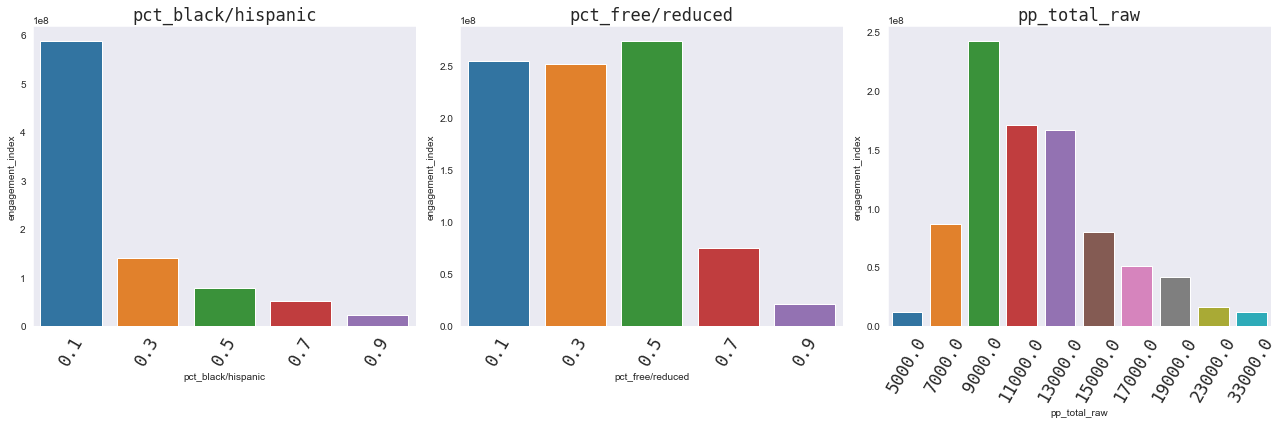

In [128]:
columns=['pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw']
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

i = 0

for column in columns:
    data=df.groupby(column).engagement_index.sum().reset_index()
    data[column]=round(data[column],2)
    sns.barplot(data=data, y='engagement_index', x=column, ax=ax[i])
    ax[i].set_title(f'{column}', fontsize=17, fontname='monospace')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=60, fontsize=17, fontname='monospace')
    i = i + 1
plt.tight_layout()
plt.show()   

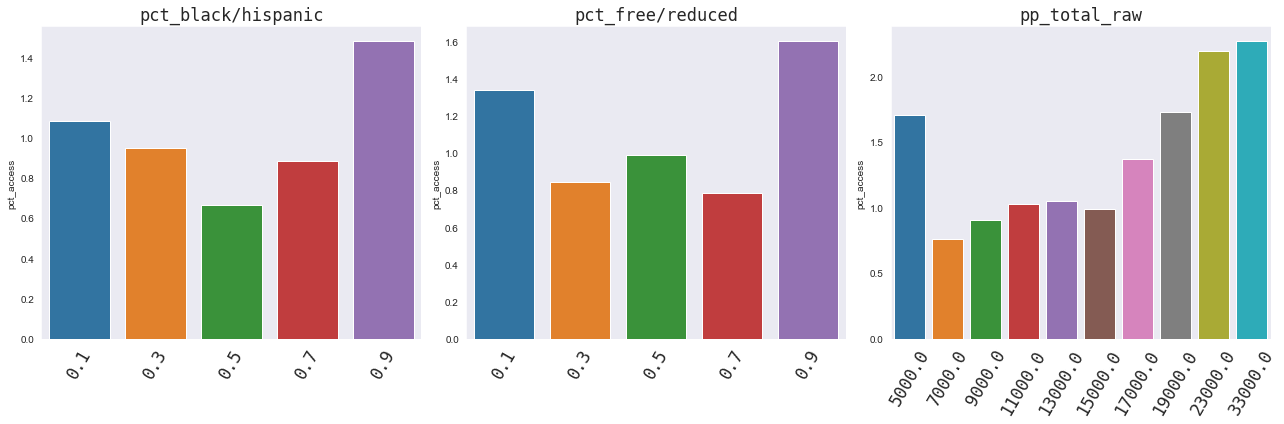

In [135]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

i = 0

for column in columns:
    data=df.groupby(column).pct_access.mean().reset_index()
    data[column]=round(data[column],2)
    sns.barplot(data=data, y='pct_access', x=column, ax=ax[i])
    ax[i].set_title(f'{column}', fontsize=17, fontname='monospace')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=60, fontsize=17, fontname='monospace')
    ax[i].set_xlabel("")
    i = i + 1
plt.tight_layout()
plt.show()

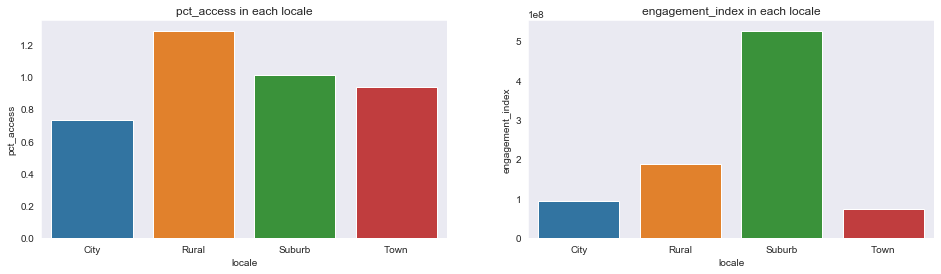

In [131]:
temp3=df.groupby('locale').pct_access.mean().to_frame().reset_index()
temp4=df.groupby('locale').engagement_index.sum().to_frame().reset_index()
f, ax = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(data=temp3,x='locale',y='pct_access', ax=ax[0])
ax[0].set_title('pct_access in each locale')

sns.barplot(data=temp4,x='locale', y='engagement_index', ax=ax[1])
ax[1].set_title('engagement_index in each locale')

plt.show()